### Genome-wide perturb-seq

This notebook prepares a dataset from a [paper with giant Perturb-seq experiments](https://www.cell.com/cell/fulltext/S0092-8674(22)00597-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422005979%3Fshowall%3Dtrue) applied to all expressed genes or all essential genes.

Here we tidy the dataset and carry out a simple exploration in scanpy.

We start from a pseudo-bulk version where all cells are added together within each perturbation. 

This study is CRISPRi (knockdown, not knockout).


In [2]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

import anndata
import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#      visualization settings
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# I prefer to specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbation_data")

# Universal
geneAnnotationPath = "../accessory_data/gencode.v35.annotation.gtf.gz"       # Downloaded from https://www.gencodegenes.org/human/release_35.html
humanTFPath =  "../accessory_data/humanTFs.csv"                              # Downloaded from http://humantfs.ccbr.utoronto.ca/download.php
humanEpiPath = "../accessory_data/epiList.csv"                               # Downloaded from https://epifactors.autosome.org/description 
cellcycleGenePath = "../accessory_data/regev_lab_cell_cycle_genes.txt"

# Replogle2 Specific
dataset_name = "replogle2"
perturbEffectTFOnlyPath = "setup/replogle2TFOnly.csv"                         # a path to store temp file
perturbEffectFullTranscriptomePath = "setup/replogle2FullTranscriptome.csv"   # a path to store temp file

### Load expression data & set up cell metadata

In [ ]:
expression_quantified = sc.read_h5ad(f"not_ready/{dataset_name}/K562_gwps_raw_bulk_01.h5ad")
expression_quantified.var_names = ingestion.convert_ens_to_symbol(
    expression_quantified.var_names, 
    gtf=geneAnnotationPath,
    strip_version=True,
)
expression_quantified

### Fill `perturbation` & `is_control` and find TF's

In [ ]:
human_tfs = pd.read_csv(humanTFPath)
human_tfs = human_tfs.loc[human_tfs["Is TF?"]=="Yes",:]
expression_quantified.obs["gene_symbol"] = [s.split("_")[1] for s in expression_quantified.obs.index]
expression_quantified.obs["is_tf"] = expression_quantified.obs["gene_symbol"].isin(human_tfs["HGNC symbol"])
expression_quantified.obs["ensembl_id"] = [s.split("_")[3] for s in expression_quantified.obs.index]
expression_quantified.obs["is_control"]     = expression_quantified.obs["gene_symbol"].str.contains("non")
expression_quantified.obs["is_control_int"] = expression_quantified.obs["gene_symbol"].str.contains("non").astype("int")
expression_quantified.obs["perturbation"] = expression_quantified.obs["gene_symbol"]
controls = expression_quantified.obs.query("is_control")["perturbation"]
expression_quantified.obs["is_tf"].value_counts()

### Normalization

In [ ]:
pseudobulk = expression_quantified.copy()
pseudobulk.raw = pseudobulk
pseudobulk.X = ingestion.deseq2Normalization(pseudobulk.X.T).T

In [ ]:
""" Sanity check: expression for house keeping genes are relatively stable """
fig, axes = plt.subplots(1, 2, figsize=(8,2))
axes[0].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'ACTB' ]], bins=100, label="ACTB" )
axes[1].hist(pseudobulk.raw.X[:, [idx for idx, n in enumerate(pseudobulk.raw.var.index) if n.upper() == 'GAPDH']], bins=100, label="GAPDH")
axes[0].legend()
axes[1].legend()
plt.suptitle("Expression across pseudobulk samples")
plt.show()

In [ ]:
plt.figure(figsize=(3,3))
logbins = np.geomspace(
    pseudobulk.raw.X.sum(axis=0).min(),                    
    pseudobulk.raw.X.sum(axis=0).max(), 
    100)
plt.hist(pseudobulk.raw.X.sum(axis=0), 
         bins=logbins, 
         log=True, 
         color="orange")
plt.xscale('log')
plt.show()

In [ ]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(
    pseudobulk.raw.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="before DESeq2 norm")
axes[1].hist(
    pseudobulk.X.sum(axis=1), 
    bins=100, 
    log=True, 
    label="after DESeq2 norm")
axes[0].legend()
axes[1].legend()
plt.show()

In [ ]:
""" Check an exmaple (correlation at expression scale and at logFC scale) """

TFBePerturb = 'ABCF1'
display(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].obs)
expr1 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]
expr2 = pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]

controlExpr  = pseudobulk[pseudobulk.obs.is_control, :].X
c1 = np.median(controlExpr.copy(), axis=0)

fig, axes = plt.subplots(1,2,figsize=(7,3))
logFC1 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[0,:]/c1)
logFC2 = np.log2(pseudobulk[pseudobulk.obs.perturbation == TFBePerturb].X[1,:]/c1)
validGeneEntry = np.isfinite(logFC1) & np.isfinite(logFC2)
logFC1 = logFC1[validGeneEntry]
logFC2 = logFC2[validGeneEntry]
print(logFC1.shape, logFC2.shape)
axes[0].scatter(expr1 , expr2 , s=0.2)
axes[0].plot(np.linspace(-1,50,50), np.linspace(-1,50,50), color='red', lw=0.5)
axes[1].scatter(logFC1, logFC2, s=0.2)
axes[1].plot(np.linspace(-1,1,50), np.linspace(-1,1,50), color='red', lw=0.5)
spearmanr(logFC1, logFC2)

### Consistency w/ Perturbation Direction

In [ ]:
# If verbose is set to True, display disconcordant trials and their controls

# Using the fold_expr field it stored in .obs 
# For perturbations where fold_expr = 0, some
# pct_expr = -1, denoting a knockout;
# others are nan, denoting lack of data or control run
fc = pseudobulk.obs.fold_expr.copy()
fc[pseudobulk.obs.pct_expr == -1] = 1e-2  # knockout
logFC = np.log2(fc)
logFC[np.isnan(logFC)] = -999             # control or no data

# Visualize the CRISPRi performance
validLogFC = logFC[logFC != -999]
rangeMin = np.floor(np.min(validLogFC))
rangeMax = np.ceil (np.max(validLogFC))
plt.figure(figsize=(4,2.5))
plt.hist(validLogFC, 
         bins=np.linspace(rangeMin, 
                          rangeMax, 
                          int((rangeMax-rangeMin)*3+1)), 
         label="Per Trial")
plt.axvline(0, 0, 1, color='red', label="No Change")
plt.xlabel("Log2 Fold Change (perturbed/control)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Label knockdown outcome
status = np.full(logFC.shape[0], "NA", dtype=object)
status[(logFC <  0) & (logFC != -999)] = "Yes"
status[(logFC >= 0)] = "No"

pseudobulk.obs["consistentW/Perturbation"] = status
pseudobulk.obs["logFC"] = logFC
Counter(status)

### Consistency across replications

In [ ]:
print(f"Of {pseudobulk.n_obs} observations, {len(set(pseudobulk.obs.perturbation))} unique perturbagen")

In [ ]:
# !! A very small proportion of perturbations have replications
correlations = ingestion.computeCorrelation(pseudobulk, verbose=True)
pseudobulk.obs["spearmanCorr"] = correlations[0]
pseudobulk.obs[ "pearsonCorr"] = correlations[1]

### Perturbation Effect

In [ ]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv(humanEpiPath, index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

### How big are the effects?

We examine different quantitative measures that answer this question. Some discriminate poorly among large effects (p-values all ~=0), and some discriminate poorly among small effects (count of DE genes). 

In [ ]:
""" If want to look at bigness on TF only """
TFVar = [i for i,p in enumerate(pseudobulk.var.index) if p in TFDict or p in EpiDict]
pseudobulkTFOnly = pseudobulk[:, TFVar].copy()
ingestion.quantifyEffect(adata=pseudobulkTFOnly, 
                         fname=perturbEffectTFOnlyPath, 
                         group=None, 
                         diffExprFC=False, 
                         prefix="TFOnly", 
                         withDEG=False, 
                         withMI=False)

In [ ]:
ingestion.quantifyEffect(adata=pseudobulk, 
                         fname=perturbEffectFullTranscriptomePath, 
                         group=None,
                         diffExprFC=False, 
                         prefix="",
                         withDEG=False, 
                         withMI=False)

listOfMetrics = ["DEG", "MI", "logFCMean", "logFCNorm2", "logFCMedian"]
for m in listOfMetrics:
    pseudobulk.obs[f"TFOnly{m}"] = pseudobulkTFOnly.obs[f"TFOnly{m}"]

In [ ]:
metricOfInterest = ["mean_leverage_score", 'energy_test_p_value', 'anderson_darling_counts', 
                    'mann_whitney_counts', 'logFCNorm2']
ingestion.checkPerturbationEffectMetricCorrelation(pseudobulk, metrics=metricOfInterest)

In [17]:
# Unable to look at everything
# Thus, look only at perturbation that results in more than 1000 DEGs
ingestion.visualizePerturbationEffect(
    pseudobulk[pseudobulk.obs.mann_whitney_counts > 1000], 
    metrics=metricOfInterest, 
    TFDict=TFDict, 
    EpiDict=EpiDict
)

NameError: name 'metricOfInterest' is not defined

In [ ]:
for idx, p in enumerate(sorted(set([(i,j) for i,j in pseudobulk.obs[['perturbation', 'logFCNorm2']].to_numpy()]), key=lambda x: x[1])):
    print(idx, p)

In [ ]:
ingestion.visualizePerturbationMetadata(pseudobulk, 
                                        x="mann_whitney_counts", 
                                        y="logFC", 
                                        style="consistentW/Perturbation", 
                                        hue="logFCNorm2", 
                                        markers=['^', 'o'],
                                        s=25)
pseudobulk.obs.head()

### Basic EDA

In [ ]:
sc.pp.log1p(pseudobulk)
sc.pp.highly_variable_genes(pseudobulk, n_bins=50, n_top_genes = pseudobulk.var.shape[0], flavor = "seurat_v3" )
print(pseudobulk.var.shape)
print(pseudobulk.var.columns)
pseudobulk.var.head()

In [ ]:

sc.pl.highly_variable_genes(pseudobulk)
with warnings.catch_warnings():
    sc.tl.pca(pseudobulk, n_comps=100)
sc.pp.neighbors(pseudobulk)
sc.tl.umap(pseudobulk)
clusterResolutions = []
sc.tl.leiden(pseudobulk)

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4.5]
sc.pl.umap(pseudobulk, color = [
    "is_control_int",
    'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered',
       'control_expr', 'fold_expr', 
       'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value',
       'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI',
       'mitopercent', 'TE_ratio', 'cnv_score_z',
])

In [ ]:
""" Keep everything that gets correctly knocked down. -999 applies to controls and unmeasured perturbed genes."""
pseudobulk = pseudobulk[(pseudobulk.obs.logFC < 0) | (pseudobulk.obs.logFC == -999),:].copy()

In [ ]:
perturbed_genes = set(list(pseudobulk.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(pseudobulk.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(pseudobulk.var.index)
print(len(perturbed_genes))
print("These genes were perturbed but not measured:")
print(len(perturbed_but_not_measured_genes))
pseudobulk.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
pseudobulk.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
pseudobulk = ingestion.describe_perturbation_effect(pseudobulk, "knockdown")

In [ ]:
os.makedirs(f"perturbations/{dataset_name}", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}/test.h5ad")

### Only TF's

Below, we subset just the samples where TF's are perturbed (and the controls).

In [7]:
pseudobulk = sc.read_h5ad(f"perturbations/{dataset_name}/test.h5ad")
TFList = pd.read_csv(humanTFPath, index_col=0).iloc[:, [1,3]]
pseudobulk.obs = pseudobulk.obs.merge(TFList, left_on = "perturbation", right_on = "HGNC symbol", how = "left")
pseudobulk.obs["Is TF?"] = pseudobulk.obs["Is TF?"].fillna("No")
print(pseudobulk.obs["Is TF?"].value_counts())
pseudobulk = pseudobulk[pseudobulk.obs["is_control"] | (pseudobulk.obs["Is TF?"]=="Yes"), :]
pseudobulk.uns["perturbed_and_measured_genes"]     = [g for g in pseudobulk.uns["perturbed_and_measured_genes"]  
                                                      if g in set(pseudobulk.obs["perturbation"])]
pseudobulk.uns["perturbed_but_not_measured_genes"] = [g for g in pseudobulk.uns["perturbed_but_not_measured_genes"] 
                                                      if g in set(pseudobulk.obs["perturbation"])]
print(pseudobulk.uns)
os.makedirs(f"perturbations/{dataset_name}_tf_only", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}_tf_only/test.h5ad")

Is TF?
No     9252
Yes    1689
Name: count, dtype: int64
OverloadedDict, wrapping:
	{'hvg': {'flavor': 'seurat_v3'}, 'leiden': {'params': {'n_iterations': -1, 'random_state': 0, 'resolution': 1}}, 'log1p': {}, 'neighbors': {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'random_state': 0}}, 'pca': {'params': {'use_highly_variable': True, 'zero_center': True}, 'variance': array([1.0760996 , 0.67853737, 0.44488195, 0.3002128 , 0.22484879,
       0.16062291, 0.14863642, 0.131709  , 0.12376022, 0.10616101,
       0.09309376, 0.08144835, 0.07646364, 0.0735774 , 0.05987897,
       0.05835764, 0.0567736 , 0.05220428, 0.05017737, 0.04898355,
       0.04750114, 0.04498466, 0.04281035, 0.04168032, 0.04070834,
       0.03891734, 0.03783587, 0.0369512 , 0.03578322, 0.03480855,
       0.03414743, 0.03278113, 0.03217657, 0.03161468, 0.02981188,
       0.02950421, 0.02855336, 0.02805476, 0.02775101, 0.027307

### Large effects only

Below, we subset only the largest effects using the leverage score defined in the original paper. 

OverloadedDict, wrapping:
	{'hvg': {'flavor': 'seurat_v3'}, 'leiden': {'params': {'n_iterations': -1, 'random_state': 0, 'resolution': 1}}, 'log1p': {}, 'neighbors': {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'random_state': 0}}, 'pca': {'params': {'use_highly_variable': True, 'zero_center': True}, 'variance': array([1.0760996 , 0.67853737, 0.44488195, 0.3002128 , 0.22484879,
       0.16062291, 0.14863642, 0.131709  , 0.12376022, 0.10616101,
       0.09309376, 0.08144835, 0.07646364, 0.0735774 , 0.05987897,
       0.05835764, 0.0567736 , 0.05220428, 0.05017737, 0.04898355,
       0.04750114, 0.04498466, 0.04281035, 0.04168032, 0.04070834,
       0.03891734, 0.03783587, 0.0369512 , 0.03578322, 0.03480855,
       0.03414743, 0.03278113, 0.03217657, 0.03161468, 0.02981188,
       0.02950421, 0.02855336, 0.02805476, 0.02775101, 0.02730792,
       0.02657875, 0.0261285 , 0.02566743, 0.02553968

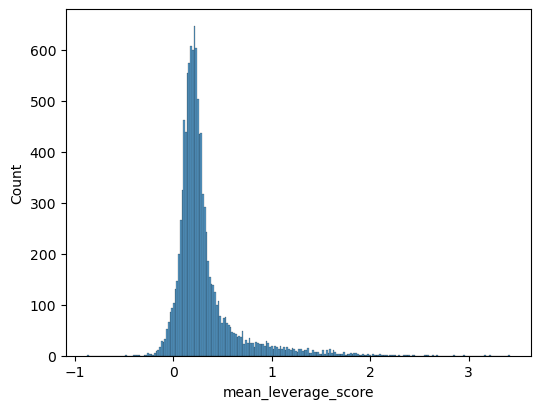

In [6]:
pseudobulk = sc.read_h5ad(f"perturbations/{dataset_name}/test.h5ad")
sns.histplot(pseudobulk.obs["mean_leverage_score"])
pseudobulk = pseudobulk[pseudobulk.obs["is_control"] | (pseudobulk.obs["mean_leverage_score"]>=0.6), :]
pseudobulk.uns["perturbed_and_measured_genes"]     = [g for g in pseudobulk.uns["perturbed_and_measured_genes"]  
                                                      if g in set(pseudobulk.obs["perturbation"])]
pseudobulk.uns["perturbed_but_not_measured_genes"] = [g for g in pseudobulk.uns["perturbed_but_not_measured_genes"] 
                                                      if g in set(pseudobulk.obs["perturbation"])]
print(pseudobulk.uns)
os.makedirs(f"perturbations/{dataset_name}_large_effect", exist_ok = True)
pseudobulk.write_h5ad(f"perturbations/{dataset_name}_large_effect/test.h5ad")